# 2018 Fantasy Hockey Draft Prep
This is a jupyter notebook which was mainly used to prep for my 2018 fantasy hockey draft.

In [73]:
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import csv
%matplotlib inline
pd.options.display.max_rows = 6

In [74]:
# Helper Functions

# We notice that pimFValue has some very large values associated with it. 
# This is because certain players have exceptionally high seasons with respect to PIMs which come from one-off PIM events. 
# For example in 2018 Michael Haley had 212 PIM, 39 of which came in one game on Jan23. 
# In previous seasons the highest season PIM count he ever recorded was 128. 
# Therefore given an extremely high PIM count is unlikely to translate into the same level of future
# PIMs we cap the pimFValue at a certain percentile.

def pimFValue_adjust(df,percentile):
    df['pimFValue']= df['pimFValue'].apply(max_pimFValue_calc, args=(df['pimFValue'].quantile(percentile),))
    return df['pimFValue']

def max_pimFValue_calc(row,max_pimFValue):
    x = min(row,max_pimFValue)
    return x

# Import Data from SQL into Pandas Dataframe

Player data was stored in a Postgres database.

In [75]:
conn = pg.connect(database="Fantasy2018",user="postgres", password=" ")
df = pd.read_sql('SELECT * FROM playerstats', conn)
df

,rk,player,age,pos,team,gp,g,a,pts,plusminus,...,sog_percent,toi,atoi,blk,hit,fow,fol,fo_percent,season,ppp
0,463,Kevin Labanc\labanke01,22,RW,SJS,77,11,29,40,-6,...,7.1,1105,14.350649,23.0,31,5.0,11.0,31.3,2018,17
1,144,Evander Kane\kaneev01,22,LW,WPG,63,19,22,41,-7,...,7.6,1278,20.283333,36.0,173,45.0,60.0,42.9,2014,5
2,687,Ben Smith\smithbe01,24,RW,CHI,1,1,0,1,1,...,100.0,18,18.350000,0.0,1,0.0,2.0,0.0,2013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10539,850,Jesse Winchester\winchje01,24,C,OTT,1,0,0,0,0,...,0.0,14,14.000000,0.0,1,0.0,0.0,0.0,2008,0
10540,851,Bryan Young\youngbr02,21,D,EDM,2,0,0,0,-1,...,0.0,4,2.133333,0.0,1,0.0,0.0,0.0,2008,0
10541,852,Ilya Zubov\zubovil01,20,C,OTT,1,0,0,0,0,...,0.0,15,14.633333,0.0,3,2.0,3.0,40.0,2008,0


# Create FantasyValue Function

To calculate this we look at the final rosters of the top three teams from my league in the 2017-2018 season. Yahoo supplies us with the rosters of the final teams so I have estimated who the top 13 players (3C,3RW,3LW,4D) on each team were. For these players I take their season per game stats, and for each team sum these statistics. Averaging across the top three teams we see they have the following per-game stats:

$$Top3Gpg = 3.84$$
$$Top3Apg=6.34$$
$$Top3PIMpg=7.47$$
$$Top3PPPpg=2.92$$
$$Top3SOGpg=35.37$$
$$Top3HITpg=15.45$$

Then to calculate the FantasyValue per player we use:

$$FantasyValue = \beta_{G}\frac{PlayerGpg}{Top3Gpg} + \beta_{A}\frac{PlayerApg}{Top3Apg} + ... + \beta_{Hit}\frac{PlayerHITpg}{Top3HITpg}$$

Where the $\beta$ terms are weights that can be adjusted as needed based on the user's preferences.

To begin we assign the Top3 stats to variables, and set all $\beta$ terms equal to 1.

In [76]:
Top3Stats ={'g':3.84,'a':6.34,'pim':7.47,'ppp':2.92,'sog':35.37,'hit':15.45}
FantasyValueBeta = {'g':1,'a':1,'pim':1,'ppp':1,'sog':1,'hit':1}

# Caculate FantasyValue & Vizualize Distribution

Calculates GoonFValue and OffenceFValue summary statistics to give new intuition of what contributes to TotalFValue 

In [77]:
for key,value in Top3Stats.items():
    df[key+'FValue'] = ((df[key]/df['gp'])/Top3Stats[key]) * FantasyValueBeta[key]

# Adjust pim f_value @ .95 percentile
df['pimFValue'] = pimFValue_adjust(df,.95)
    
df['TotalFValue'] = df['gFValue'] + df['aFValue'] + df['pimFValue'] + df['pppFValue'] + df['sogFValue'] + df['hitFValue']
df['GoonFValue'] = df['pimFValue'] + df['hitFValue']
df['OffenceFValue'] = df['gFValue'] + df['aFValue'] + df['pppFValue'] + df['sogFValue']

Histograms to explore how the fantasy value is distributed

Blue - All players

Orange - Players with at least 25 GP in a season and > 0.5 Fantasy Value

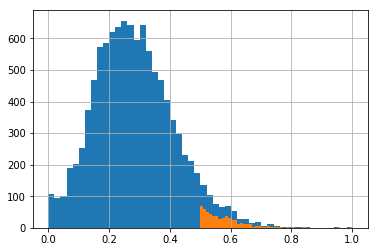

In [78]:
df['TotalFValue'].hist(bins=50)
dfhighend = df[(df['gp']>25) & (df['TotalFValue']>0.5)]
dfhighend['TotalFValue'].hist(bins=50)

Print out players who have performed at 0.75
TotalFValue or better with > 25GP for any season

In [79]:
dfveryhighend=df[(df['gp']>25) & (df['TotalFValue']>0.70)]
dfveryhighend[['player','season','TotalFValue','GoonFValue','OffenceFValue']]

,player,season,TotalFValue,GoonFValue,OffenceFValue
1795,Alex Ovechkin\ovechal01,2016,0.727379,0.274154,0.453225
1821,Wayne Simmonds\simmowa01,2016,0.722492,0.396369,0.326123
2682,Alex Ovechkin\ovechal01,2015,0.809360,0.302817,0.506543
...,...,...,...,...,...
9693,Jarome Iginla\iginlja01,2008,0.718335,0.212856,0.505479
9716,Brenden Morrow\morrobr01,2008,0.747367,0.376643,0.370724
9753,Dion Phaneuf\phanedi01,2008,0.763757,0.398556,0.365201


Histogram of Various Stat Categories Distribution (note PIM is capped)

Text(0.5,0,'hitFValue')

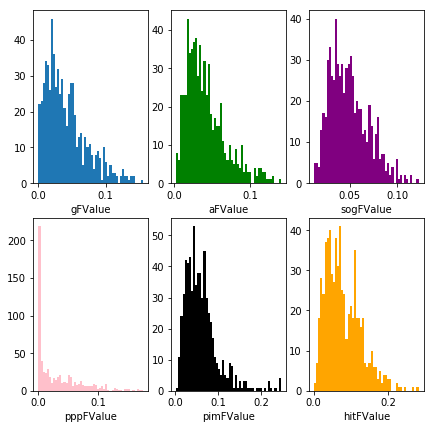

In [80]:
df2018stats = df[(df['gp']>25) & (df['season']==2018)]
fig, axes = plt.subplots(2, 3, figsize=(7,7))
axes[0][0].hist(df2018stats['gFValue'],bins=50)
axes[0][0].set_xlabel('gFValue')
axes[0][1].hist(df2018stats['aFValue'],bins=50,color='green')
axes[0][1].set_xlabel('aFValue')
axes[0][2].hist(df2018stats['sogFValue'],bins=50,color='purple')
axes[0][2].set_xlabel('sogFValue')
axes[1][0].hist(df2018stats['pppFValue'],bins=50,color='pink')
axes[1][0].set_xlabel('pppFValue')
axes[1][1].hist(df2018stats['pimFValue'],bins=50,color='black')
axes[1][1].set_xlabel('pimFValue')
axes[1][2].hist(df2018stats['hitFValue'],bins=50,color='orange')
axes[1][2].set_xlabel('hitFValue')

# GoonFValue vs OffenceFValue Distribution

Here we want to vizualize the distribution of the top 100 fantasy assets based on how they fare in the goon categories (PIM/Hits) and the offence categories (G/A/SOG/PPP). We use a hexbin graph to do so.

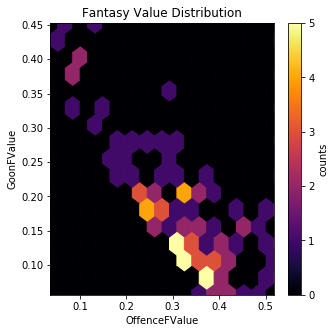

In [81]:
# Gets the top 100 fantasy assets
df2018stats = df2018stats.sort_values(['TotalFValue'],ascending=False)
df2018statstop100 = df2018stats.head(100)
df2018statstop100

#Creates a plot
xmin = df2018statstop100['OffenceFValue'].min()
xmax = df2018statstop100['OffenceFValue'].max()
ymin = df2018statstop100['GoonFValue'].min()
ymax = df2018statstop100['GoonFValue'].max()

fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(5, 5))
hb = ax.hexbin(df2018statstop100['OffenceFValue'], df2018statstop100['GoonFValue'], gridsize=15, cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("Fantasy Value Distribution")
ax.set_xlabel('OffenceFValue')
ax.set_ylabel('GoonFValue')

cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

# Outperforming/Slumping Players

Here we will find all players in the league for two or three years and find those who most out/underperformed in 2018.

In [82]:
# Imports DFs 
df_2018 = df[df['season']==2018][['player','gp','TotalFValue','GoonFValue','OffenceFValue']]
df_2017 = df[df['season']==2017][['player','gp','TotalFValue','GoonFValue','OffenceFValue']]
df_2016 = df[df['season']==2016][['player','gp','TotalFValue','GoonFValue','OffenceFValue']]

In [83]:
# Merge DFs
slump_df = pd.merge(df_2018, df_2017, on='player',suffixes=('2018', '2017'))
slump_df = pd.merge(slump_df,df_2016,on='player')
slump_df.rename(columns={'TotalFValue': 'TotalFValue2016',
                        'GoonFValue': 'GoonFValue2016',
                       'OffenceFValue': 'OffenceFValue2016','gp':'gp2016'}, inplace=True)

slump_df['GoonAvg'] = slump_df.eval('(GoonFValue2018 + GoonFValue2017 + GoonFValue2016)/3')
slump_df['OffenceAvg'] = slump_df.eval('(OffenceFValue2018 + OffenceFValue2017 + OffenceFValue2016)/3')
slump_df['TotalAvg'] = slump_df.eval('(TotalFValue2018 + TotalFValue2017 + TotalFValue2016)/3')
slump_df['GoonChg'] = slump_df.eval('GoonFValue2018-GoonAvg')
slump_df['OffenceChg'] = slump_df.eval('OffenceFValue2018-OffenceAvg')
slump_df['TotalChg'] = slump_df.eval('TotalFValue2018-TotalAvg')

Display players who in 2018 were top 10% in TotalFValue, sorted by how much this was different than the past 3 years

In [84]:
slump_3yr = slump_df[['player','TotalChg','GoonChg','OffenceChg','TotalFValue2018','TotalAvg','gp2018']].sort_values(by=['TotalChg'])
slump_3yr = slump_3yr[slump_3yr['TotalFValue2018']>slump_3yr['TotalFValue2018'].quantile(.80)]
slump_3yr

,player,TotalChg,GoonChg,OffenceChg,TotalFValue2018,TotalAvg,gp2018
513,Wayne Simmonds\simmowa01,-0.133530,-0.099092,-0.034437,0.486639,0.620169,75
210,Radko Gudas\gudasra01,-0.100923,-0.095899,-0.005024,0.412258,0.513181,70
320,Kris Letang\letankr01,-0.089391,-0.031367,-0.058023,0.463871,0.553262,79
...,...,...,...,...,...,...,...
334,Nathan MacKinnon\mackina01,0.189460,0.038869,0.150591,0.650205,0.460745,74
442,Brandon Pirri\pirribr01,0.204728,-0.035475,0.240203,0.610849,0.406120,2
458,Mikko Rantanen\rantami01,0.219666,0.023160,0.196506,0.492206,0.272540,81


Just looking at 2017 vs. 2018 stats

In [85]:
slump_df['TotalFValue2017vs2018'] = slump_df.eval('TotalFValue2018 - TotalFValue2017')
slump_2yr = slump_df[['player','TotalFValue2017vs2018','TotalFValue2018','gp2018']].sort_values(by=['TotalFValue2017vs2018'])

# Adjust for GP
slump_2yr = slump_2yr[slump_2yr['gp2018']>20]
slump_2yr = slump_2yr[slump_2yr['TotalFValue2018']>slump_2yr['TotalFValue2018'].quantile(.80)]
slump_2yr

,player,TotalFValue2017vs2018,TotalFValue2018,gp2018
513,Wayne Simmonds\simmowa01,-0.164736,0.486639,75
210,Radko Gudas\gudasra01,-0.160188,0.412258,70
273,Nazem Kadri\kadrina01,-0.110994,0.451751,80
...,...,...,...,...
231,Erik Haula\haulaer01,0.218765,0.441610,76
458,Mikko Rantanen\rantami01,0.224813,0.492206,81
334,Nathan MacKinnon\mackina01,0.312887,0.650205,74


Graph players who were in a slump or outperformed in 2018

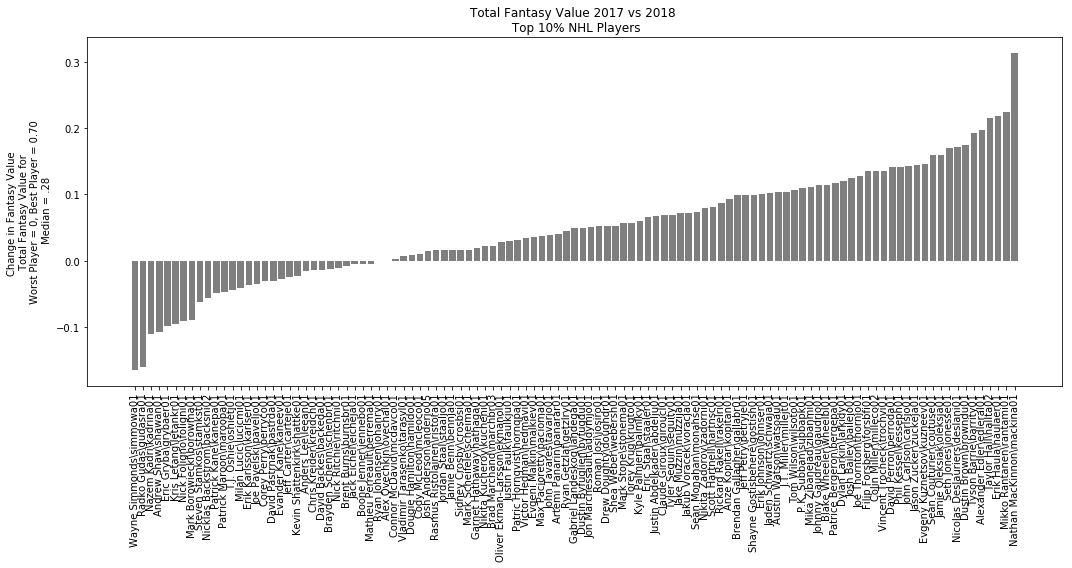

In [86]:
fig = plt.figure(figsize=(15,8))

objects = slump_2yr['player']
y_pos = np.arange(len(objects))
performance = slump_2yr['TotalFValue2017vs2018']
 
plt.bar(y_pos, performance, color='black',align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Change in Fantasy Value \n Total Fantasy Value for \n Worst Player = 0, Best Player = 0.70 \n Median = .28')
plt.title('Total Fantasy Value 2017 vs 2018 \n Top 10% NHL Players')
plt.xticks(rotation=90) 
plt.tight_layout()

plt.show()

# Write CSV File for Players Draft Aid

A script to output 2018 season information into a CSV file for use during the draft

In [87]:
# Main Dataframe
df_output = df[df['season']==2018]
df_output = df_output[['player','age','pos','team','gp','g','a','pts','plusminus','pim','atoi',
               'ppp','gFValue','aFValue','pimFValue','pppFValue','sogFValue','hitFValue','TotalFValue',
                'GoonFValue','OffenceFValue']]
df_output.to_csv('FHDraft.csv', encoding='utf-8', index=False)

# Goalies

In [88]:
g_df = pd.read_sql('SELECT * FROM goaliestats', conn)

In [89]:
# Get a group of top goalies and compare their performances over past few seasons
top_goalies = ['Pekka Rinne\\rinnepe01','Andrei Vasilevskiy\\vasilan02','Connor Hellebuyck\\helleco01',
              'Braden Holtby\\holtbbr01','Tuukka Rask\\rasktu01','Jonathan Quick\\quickjo01',
              'Sergei Bobrovsky\\bobrose01','Frederik Andersen\\anderfr01','Marc-Andre Fleury\\fleurma01',
              'John Gibson\\gibsojo02','Martin Jones\\jonesma02','Devan Dubnyk\\dubnyde01','Ben Bishop\\bishobe01',
              'Matt Murray\\murrama02','Carey Price\\priceca01','Antti Raanta\\raantan01','Corey Crawford\\crawfco01',
              'Jake Allen\\allenja01']


g_df_2018 = g_df[(g_df['player'].isin(top_goalies)) & (g_df['season']==2018)]
g_df_2017 = g_df[(g_df['player'].isin(top_goalies)) & (g_df['season']==2017)]
g_df_2016 = g_df[(g_df['player'].isin(top_goalies)) & (g_df['season']==2016)]

g_3yr = pd.merge(g_df_2018, g_df_2017, how='left', suffixes=('2018', '2017'),on=['player'])
g_3yr = pd.merge(g_3yr,g_df_2016,how='left',suffixes=('','2016'),on=['player'])
g_3yr.rename(columns={'gp': 'gp2016',
                        'w': 'w2016',
                       'svpct': 'svpct2016',
                         'gaa':'gaa2016'}, inplace=True)

g_3yr = g_3yr[['player','w2018','w2017','w2016','gaa2018','gaa2017','gaa2016','svpct2018','svpct2017','svpct2016']]
g_3yr

,player,w2018,w2017,w2016,gaa2018,gaa2017,gaa2016,svpct2018,svpct2017,svpct2016
0,Jake Allen\allenja01,27,33,26,2.75,2.42,2.35,0.906,0.915,0.920
1,Frederik Andersen\anderfr01,38,33,22,2.81,2.67,2.30,0.918,0.918,0.919
2,Ben Bishop\bishobe01,26,18,35,2.49,2.54,2.06,0.916,0.910,0.926
...,...,...,...,...,...,...,...,...,...,...
15,Tuukka Rask\rasktu01,34,37,31,2.36,2.23,2.56,0.917,0.915,0.915
16,Pekka Rinne\rinnepe01,42,31,34,2.31,2.42,2.48,0.927,0.918,0.908
17,Andrei Vasilevskiy\vasilan02,44,23,11,2.62,2.61,2.76,0.920,0.917,0.910


# Plot of Goalie GAA

Can also recreate this plot for W & SV%

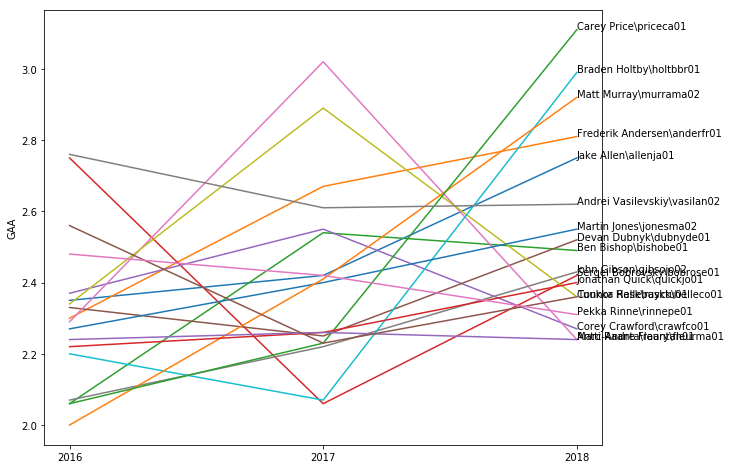

In [90]:
fig = plt.figure(figsize=(10,8))

for index,row in g_3yr.iterrows():
    plt.plot(['2016','2017','2018'],[row['gaa2016'],row['gaa2017'],row['gaa2018']],label=row['player'])
    plt.annotate(row['player'], xy=('2018',row['gaa2018']), xycoords='data')
    
plt.ylabel('GAA')
plt.show()

# Plot of Individual Goalie

Put Goalies Name in g_indiv call to have plot of all of their performance over past 3 years

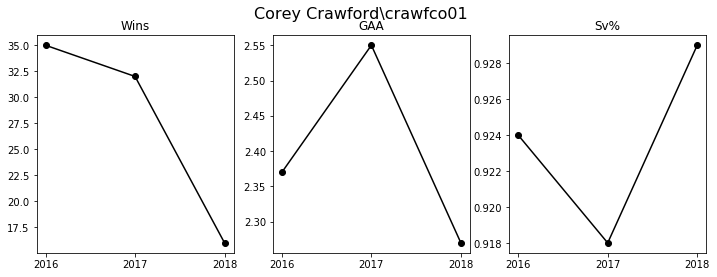

In [91]:
g_indiv = g_3yr[g_3yr['player']=='Corey Crawford\\crawfco01']

fig = plt.figure()

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].plot(['2016','2017','2018'], [g_indiv['w2016'].iloc[0],g_indiv['w2017'].iloc[0],g_indiv['w2018'].iloc[0]], 'ko-')
axes[0].set_title('Wins')

axes[1].plot(['2016','2017','2018'], [g_indiv['gaa2016'].iloc[0],g_indiv['gaa2017'].iloc[0],g_indiv['gaa2018'].iloc[0]], 'ko-')
axes[1].set_title('GAA')

axes[2].plot(['2016','2017','2018'], [g_indiv['svpct2016'].iloc[0],g_indiv['svpct2017'].iloc[0],g_indiv['svpct2018'].iloc[0]], 'ko-')
axes[2].set_title('Sv%')

fig.suptitle(g_indiv['player'].values[0], fontsize=16)

plt.show()